Cryptocurrency trading bot.

In [1]:
##%pip install python-binance==0.7.5
#%pip install python-binance

## Global constants.

In [2]:
symbol = 'OCEANUSDT'
interval = '1h'
period = 100

## Manage API keys, get all needed pair information to trade and get conversion table for price conversions.

In [19]:
# Import libraries.
from cryptocurrency.authentication import Cryptocurrency_authenticator
from cryptocurrency.exchange import Cryptocurrency_exchange
from cryptocurrency.conversion_table import get_conversion_table

# Manage API keys.
authenticator = Cryptocurrency_authenticator(use_keys=False, testnet=False)
client = authenticator.spot_client

# Get all available pair information for trading.
exchange = Cryptocurrency_exchange(client=client, directory='crypto_logs')
exchange_info = exchange.info

# Get conversion table for price conversions.
conversion_table = get_conversion_table(client=client, exchange_info=exchange_info, 
                                        offset_s=0, as_pair=True, dump_raw=False, 
                                        minimal=True, extra_minimal=False, 
                                        convert_to_USDT=False)

# Display pre-computed conversion table.
conversion_table

,symbol,base_asset,quote_asset,open,high,low,close,rolling_base_volume,rolling_quote_volume,count,bid_price,ask_price,bid_volume,ask_volume,price_change_percent,rolling_base_quote_volume,bid_ask_percent_change,bid_ask_volume_percent_change
date,,,,,,,,,,,,,,,,,,
2022-12-12 23:55:34.147,CVCBTC,CVC,BTC,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0,0.000000,0.000000,0.00000,0.00000,0.000,NaN,NaN,NaN
2022-12-12 23:55:34.147,SLPBNB,SLP,BNB,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0,0.000000,0.000000,0.00000,0.00000,0.000,NaN,NaN,NaN
2022-12-12 23:55:34.147,ROSEBNB,ROSE,BNB,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0,0.000000,0.000000,0.00000,0.00000,0.000,NaN,NaN,NaN
2022-12-12 23:55:34.147,CVCUSDT,CVC,USDT,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0,0.000000,0.000000,0.00000,0.00000,0.000,NaN,NaN,NaN
2022-12-16 03:58:31.829,BUSDVAI,BUSD,VAI,1.026000,1.026000,1.019000,1.020000,5.024200e+03,5.136013e+03,11,1.019000,1.021000,647.30000,24.20000,-0.585,5.035307e+03,0.195886,96.396128
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-16 10:50:44.381,RENUSDT,REN,USDT,0.086051,0.087667,0.081148,0.082065,1.900174e+07,1.608516e+06,8685,0.082065,0.082093,6240.00000,1630.00000,-4.632,1.960051e+07,0.034108,79.288437
2022-12-16 10:50:44.383,BTCUSDT,BTC,USDT,17407.500000,17531.730000,16890.460000,16970.480000,2.300436e+05,3.966259e+09,4961618,16970.050000,16970.590000,0.11785,0.10181,-2.511,2.337152e+05,0.003182,53.651097
2022-12-16 10:50:44.383,ACMBUSD,ACM,BUSD,2.528000,2.540000,2.356000,2.417000,4.610210e+04,1.123160e+05,1499,2.418000,2.420000,82.70000,88.10000,-4.391,4.646918e+04,0.082645,48.419204


## Pre-screen buyable base assets in pairs.

In [6]:
from cryptocurrency.conversion_table import get_new_filtered_tickers

tickers_list = get_new_filtered_tickers(conversion_table=conversion_table)
len(tickers_list)

1415

## Order book.

In [7]:
from time import sleep
import pandas as pd

def get_bid_ask_range(symbol):
    def get_order_book_depth(symbol):
        depth = client.get_order_book(symbol=symbol, 
                                      limit=5000)
        frames = {side: pd.DataFrame(data=depth[side], 
                                     columns=['price', 
                                              'quantity'], 
                                     dtype=float) 
                  for side in ['bids', 'asks']}
        frames_list = [frames[side].assign(side=side) for side in frames]
        return pd.concat(frames_list, axis='index', ignore_index=True, sort=True)
    data = get_order_book_depth(symbol=symbol)
    min_prices = data.groupby('side').price.min()
    max_prices = data.groupby('side').price.max()
    center_price = ((min_prices.loc['asks'] - max_prices.loc['bids']) + max_prices.loc['bids'])
    bid_range = (((center_price - min_prices.loc['bids']) / min_prices.loc['bids']) * 100)
    ask_range = (((max_prices.loc['asks'] - center_price) / center_price) * 100)
    return bid_range, ask_range

bid_range, ask_range = get_bid_ask_range(symbol)
bid_range, ask_range

False

In [ ]:
def get_bid_ask_range_bigger_than_threshold_percent(symbol, threshold=100):
    bid_range, ask_range = get_bid_ask_range(symbol)
    return bid_range > threshold, ask_range > threshold

get_bid_ask_range_bigger_than_threshold_percent(symbol='USTCBUSD', threshold=100)[1]

In [8]:
from tqdm import tqdm

def filter_bid_ask_range_in_loop(symbol, threshold=100):
    sleep(2.9)
    return get_bid_ask_range_bigger_than_threshold_percent(symbol=symbol, threshold=10000)[1]

while True:
    tickers_list = get_new_tickers(client=client, conversion_table=conversion_table)
    sleep(5)
    interesting_pairs = [symbol for symbol in tqdm(tickers_list) 
                         if filter_bid_ask_range_in_loop(symbol=symbol, threshold=10000)]
    if len(interesting_pairs) > 0:
        print(interesting_pairs)

In [9]:
#tickers_list

In [10]:
#%pip install seaborn

In [11]:
from time import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

symbol = 'USTCBUSD'
t1 = time()
depth = client.get_order_book(symbol=symbol, limit=5000)
t2 = time()
print('Elapsed time:', (t2 - t1), 'seconds')
frames = {side: pd.DataFrame(data=depth[side], columns=['price', 'quantity'], dtype=float) 
          for side in ['bids', 'asks']}
frames_list = [frames[side].assign(side=side) for side in frames]
data = pd.concat(frames_list, axis='index', ignore_index=True, sort=True)
t2 = time()
print('Elapsed time:', (t2 - t1), 'seconds')
max_quantities = data.groupby('side').quantity.max()
height_based_direction = ((max_quantities.loc['asks'] - max_quantities.loc['bids']) / max_quantities.loc['bids'])
height_based_direction *= 100
height_based_direction

Elapsed time: 0.18190383911132812 seconds
Elapsed time: 0.1888434886932373 seconds


196.78127242175293

In [12]:
max_quantities.loc['bids'], max_quantities.loc['asks']

(4837657.0, 14357260.0)

In [13]:
data[data['side'] == 'bids'].shape[0], data[data['side'] == 'asks'].shape[0]

(2602, 5000)

In [14]:
min_prices = data.groupby('side').price.min()
max_prices = data.groupby('side').price.max()
asks_width = ((max_prices.loc['asks'] - min_prices.loc['asks']) / max_prices.loc['asks'])
bids_width = ((max_prices.loc['bids'] - min_prices.loc['bids']) / max_prices.loc['asks'])
width_based_direction = ((asks_width / (asks_width + bids_width)) * 100)
width_based_direction

39.66757498060798

In [15]:
center_price = ((min_prices.loc['asks'] - max_prices.loc['bids']) + max_prices.loc['bids'])
bid_range = (((center_price - min_prices.loc['bids']) / min_prices.loc['bids']) * 100)
ask_range = (((max_prices.loc['asks'] - center_price) / center_price) * 100)
bid_range, ask_range

(1628.0547181187821, 61.91689313816442)

In [16]:
depth_bullishness = height_based_direction + width_based_direction
depth_bullishness

236.4488474023609

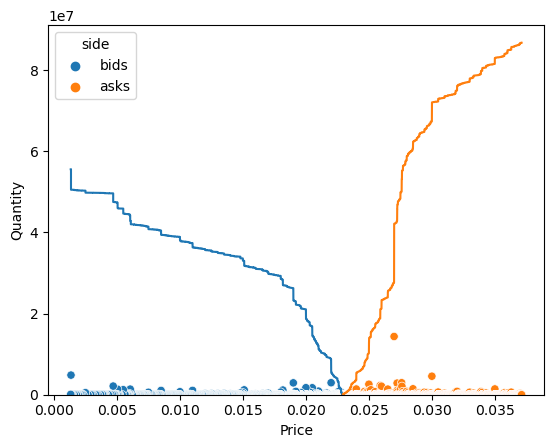

In [17]:
fig, ax = plt.subplots()

sns.ecdfplot(x='price', weights='quantity', stat='count', complementary=True, data=frames['bids'], ax=ax)
sns.ecdfplot(x='price', weights='quantity', stat='count', data=frames['asks'], ax=ax)
sns.scatterplot(x='price', y='quantity', hue='side', data=data, ax=ax)

ax.set_xlabel('Price')
ax.set_ylabel('Quantity')

plt.show()

## Smaller bid/ask split (no depth).

In [18]:
df = pd.DataFrame(client.get_ticker())
split = df[df['symbol'] == symbol][['bidQty', 'askQty']].iloc[0].astype(float)
#(((split.loc['askQty'] - split.loc['bidQty']) / split.loc['bidQty']) * 100)
split

bidQty    10058.0
askQty     8144.0
Name: 2057, dtype: float64